# Multi-Timeframe Backtesting Engine for EURUSD and XAUUSD

## Strategy Overview
- **Base Timeframe**: 5-minute data
- **Higher Timeframes**: 1H, 4H, 1D (for confirmation)
- **Indicators**: EMA(10/50), RSI, ATR, ADX, Fibonacci, Support/Resistance
- **Capital**: $100 starting balance
- **Risk per Trade**: 2%
- **Risk-Reward**: 1:3 (SL = ATR * 1.5, TP = 3 * SL)

## Cell 1: Imports & Configuration

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import os
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import argrelextrema

# Technical analysis library
try:
    import ta
except ImportError:
    print("Installing ta library...")
    !pip install ta
    import ta

warnings.filterwarnings('ignore')

# Global Configuration
CONFIG = {
    'initial_capital': 100,
    'risk_per_trade': 0.02,  # 2% risk per trade
    'risk_reward_ratio': 3,   # 1:3 risk-reward
    'base_timeframe': '5',    # 5-minute base
    'higher_timeframes': ['60', '240', '1440'],  # 1H, 4H, 1D
    'atr_multiplier': 1.5,    # Stop loss multiplier
    'ema_fast': 10,
    'ema_slow': 50,
    'rsi_period': 14,
    'rsi_buy_threshold': 55,
    'rsi_sell_threshold': 45,
    'atr_period': 14,
    'adx_period': 14,
    'adx_threshold': 20,
    'fib_levels': [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1.0],
    'sr_window': 20,  # Window for support/resistance detection
}

# Data paths
DATA_DIR = 'data'
SYMBOLS = ['EURUSD', 'XAUUSD']

print("✅ Configuration loaded successfully")
print(f"Initial Capital: ${CONFIG['initial_capital']}")
print(f"Risk per Trade: {CONFIG['risk_per_trade']*100}%")
print(f"Risk-Reward Ratio: 1:{CONFIG['risk_reward_ratio']}")

Installing ta library...
  Using cached ta-0.11.0.tar.gz (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29421 sha256=e35764ee8477716e24a56e1f5107cf01df537e15a2a4b24d1c0a7e3733866fc8
  Stored in directory: c:\users\dax\appdata\local\pip\cache\wheels\5c\a1\5f\c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta
✅ Configuration loaded successfully
Initial Capital: $100
Risk per Trade: 2.0%
Risk-Reward Ratio: 1:3
  Using cached ta-0.11.0.tar.gz (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29421 sha256=e35764ee8477716e24a56e1f5107cf01df537e15a2a4b24d1c0a7e3733866fc8
  Stored in directory: c:\users\dax\appdata\local\pip\cache\wheels\5c\a1\5f\c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta
✅ Con

## Cell 2: Data Loader with Multi-Timeframe Alignment

In [6]:
def load_symbol_data(symbol, base_tf='5', higher_tfs=['60', '240', '1440']):
    """
    Load and align multiple timeframes for a symbol.
    
    Parameters:
    - symbol: 'EURUSD' or 'XAUUSD'
    - base_tf: Base timeframe (default '5' for 5-minute)
    - higher_tfs: List of higher timeframes to align
    
    Returns:
    - DataFrame with aligned multi-timeframe data
    """
    print(f"\n📊 Loading {symbol} data...")
    
    # Load base timeframe (5-minute)
    base_file = os.path.join(DATA_DIR, symbol, f"{symbol}{base_tf}.csv")
    
    if not os.path.exists(base_file):
        raise FileNotFoundError(f"Base file not found: {base_file}")
    
    # Read base data (no headers, tab-separated)
    df = pd.read_csv(base_file, header=None, sep='\t', names=['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume'])
    
    # Parse datetime and set as index
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)
    df.sort_index(inplace=True)
    
    # Ensure numeric columns (already named correctly)
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Drop any rows with NaN in essential columns
    df.dropna(subset=['Open', 'High', 'Low', 'Close'], inplace=True)
    
    print(f"  Base timeframe ({base_tf}m): {len(df)} candles")
    
    # Load and align higher timeframes
    for htf in higher_tfs:
        htf_file = os.path.join(DATA_DIR, symbol, f"{symbol}{htf}.csv")
        
        if not os.path.exists(htf_file):
            print(f"  ⚠️ Warning: {htf}m file not found, skipping...")
            continue
        
        # Read higher timeframe data (no headers, tab-separated)
        df_htf = pd.read_csv(htf_file, header=None, sep='\t', names=['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume'])
        
        # Parse datetime and set as index
        df_htf['Datetime'] = pd.to_datetime(df_htf['Datetime'])
        df_htf.set_index('Datetime', inplace=True)
        df_htf.sort_index(inplace=True)
        
        # Ensure numeric (already named correctly)
        for col in ['Open', 'High', 'Low', 'Close']:
            df_htf[col] = pd.to_numeric(df_htf[col], errors='coerce')
        
        # Rename columns to include timeframe suffix
        suffix = f"_{htf}m"
        df_htf = df_htf.rename(columns={
            'Open': f'Open{suffix}',
            'High': f'High{suffix}',
            'Low': f'Low{suffix}',
            'Close': f'Close{suffix}',
        })
        
        # Keep only OHLC columns
        cols_to_keep = [col for col in df_htf.columns if col.endswith(suffix)]
        df_htf = df_htf[cols_to_keep]
        
        # Forward-fill higher timeframe data to match base timeframe
        df = df.join(df_htf, how='left')
        df[cols_to_keep] = df[cols_to_keep].fillna(method='ffill')
        
        print(f"  Higher timeframe ({htf}m): {len(df_htf)} candles → aligned to base")
    
    # Final cleanup
    df.dropna(inplace=True)
    
    print(f"✅ {symbol} data loaded: {len(df)} aligned candles")
    print(f"   Date range: {df.index[0]} to {df.index[-1]}")
    
    return df

# Test loading data
print("Testing data loader...")
test_df = load_symbol_data('EURUSD', base_tf=CONFIG['base_timeframe'], 
                           higher_tfs=CONFIG['higher_timeframes'])
print(f"\nColumns: {list(test_df.columns)}")
print(f"\nFirst 3 rows:")
print(test_df.head(3))

Testing data loader...

📊 Loading EURUSD data...
  Base timeframe (5m): 100000 candles
  Higher timeframe (60m): 100000 candles → aligned to base
  Higher timeframe (240m): 25848 candles → aligned to base
  Higher timeframe (1440m): 5015 candles → aligned to base
✅ EURUSD data loaded: 99977 aligned candles
   Date range: 2024-06-18 00:00:00 to 2025-10-17 20:55:00

Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Open_60m', 'High_60m', 'Low_60m', 'Close_60m', 'Open_240m', 'High_240m', 'Low_240m', 'Close_240m', 'Open_1440m', 'High_1440m', 'Low_1440m', 'Close_1440m']

First 3 rows:
                        Open     High      Low    Close  Volume  Open_60m  \
Datetime                                                                    
2024-06-18 00:00:00  1.07400  1.07407  1.07385  1.07397     277     1.074   
2024-06-18 00:05:00  1.07396  1.07398  1.07387  1.07387     248     1.074   
2024-06-18 00:10:00  1.07387  1.07387  1.07373  1.07373     267     1.074   

                     Hig

## Cell 3: Indicator Functions

In [7]:
def compute_ema(df, period, column='Close'):
    """Calculate Exponential Moving Average"""
    return df[column].ewm(span=period, adjust=False).mean()

def compute_rsi(df, period=14, column='Close'):
    """Calculate Relative Strength Index"""
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_atr(df, period=14):
    """Calculate Average True Range"""
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(period).mean()
    return atr

def compute_adx(df, period=14):
    """Calculate Average Directional Index"""
    plus_dm = df['High'].diff()
    minus_dm = df['Low'].diff()
    
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr = compute_atr(df, period)
    
    plus_di = 100 * (plus_dm.ewm(alpha=1/period).mean() / tr)
    minus_di = 100 * (np.abs(minus_dm).ewm(alpha=1/period).mean() / tr)
    
    dx = (np.abs(plus_di - minus_di) / np.abs(plus_di + minus_di)) * 100
    adx = dx.ewm(alpha=1/period).mean()
    
    return adx

def detect_support_resistance(df, window=20, num_levels=3):
    """
    Detect support and resistance levels using swing highs and lows
    
    Returns:
    - support_levels: list of support price levels
    - resistance_levels: list of resistance price levels
    """
    # Find local maxima (resistance) and minima (support)
    highs = df['High'].values
    lows = df['Low'].values
    
    # Get indices of local extrema
    resistance_idx = argrelextrema(highs, np.greater, order=window)[0]
    support_idx = argrelextrema(lows, np.less, order=window)[0]
    
    # Get price levels
    resistance_prices = highs[resistance_idx]
    support_prices = lows[support_idx]
    
    # Cluster similar levels (within 0.1% of each other)
    def cluster_levels(levels, tolerance=0.001):
        if len(levels) == 0:
            return []
        levels_sorted = np.sort(levels)
        clusters = []
        current_cluster = [levels_sorted[0]]
        
        for level in levels_sorted[1:]:
            if abs(level - np.mean(current_cluster)) / np.mean(current_cluster) < tolerance:
                current_cluster.append(level)
            else:
                clusters.append(np.mean(current_cluster))
                current_cluster = [level]
        clusters.append(np.mean(current_cluster))
        return clusters
    
    support_levels = cluster_levels(support_prices)
    resistance_levels = cluster_levels(resistance_prices)
    
    # Return top N most recent levels
    support_levels = sorted(support_levels, reverse=True)[:num_levels]
    resistance_levels = sorted(resistance_levels, reverse=True)[:num_levels]
    
    return support_levels, resistance_levels

def compute_fibonacci_levels(df, lookback=100):
    """
    Calculate Fibonacci retracement levels based on recent swing high/low
    
    Returns:
    - fib_levels: dict with Fibonacci levels
    - trend: 'up' or 'down'
    """
    recent_data = df.tail(lookback)
    
    swing_high = recent_data['High'].max()
    swing_low = recent_data['Low'].min()
    
    diff = swing_high - swing_low
    
    # Determine trend direction
    high_idx = recent_data['High'].idxmax()
    low_idx = recent_data['Low'].idxmin()
    trend = 'up' if low_idx < high_idx else 'down'
    
    fib_levels = {}
    
    if trend == 'up':
        # Uptrend: retracement from high
        for level in CONFIG['fib_levels']:
            fib_levels[level] = swing_high - (diff * level)
    else:
        # Downtrend: retracement from low
        for level in CONFIG['fib_levels']:
            fib_levels[level] = swing_low + (diff * level)
    
    return fib_levels, trend, swing_high, swing_low

def add_all_indicators(df):
    """
    Add all technical indicators to the dataframe
    """
    print("\n📈 Computing indicators...")
    
    # Base timeframe indicators
    df['EMA_10'] = compute_ema(df, CONFIG['ema_fast'])
    df['EMA_50'] = compute_ema(df, CONFIG['ema_slow'])
    df['RSI'] = compute_rsi(df, CONFIG['rsi_period'])
    df['ATR'] = compute_atr(df, CONFIG['atr_period'])
    df['ADX'] = compute_adx(df, CONFIG['adx_period'])
    
    # Higher timeframe indicators (if columns exist)
    for tf in CONFIG['higher_timeframes']:
        close_col = f'Close_{tf}m'
        if close_col in df.columns:
            df[f'EMA_10_{tf}m'] = compute_ema(df, CONFIG['ema_fast'], close_col)
            df[f'EMA_50_{tf}m'] = compute_ema(df, CONFIG['ema_slow'], close_col)
    
    print("✅ Indicators computed")
    return df

print("✅ Indicator functions defined")

✅ Indicator functions defined


## Cell 4: Strategy Signal Generation Logic

In [8]:
def generate_signals(df, symbol_name=''):
    """
    Generate buy/sell signals based on multi-timeframe strategy
    
    Entry Rules:
    BUY:
    - EMA10 crosses above EMA50 on 5-min
    - Uptrend confirmed on 1H and 4H (EMA10 > EMA50)
    - Price above daily support
    - Price near Fibonacci 38.2% or 50% retracement
    - RSI > 55
    - ADX > 20
    
    SELL:
    - EMA10 crosses below EMA50 on 5-min
    - Downtrend confirmed on 1H and 4H (EMA10 < EMA50)
    - Price below daily resistance
    - Price near Fibonacci 61.8% retracement
    - RSI < 45
    - ADX > 20
    """
    print(f"\n🎯 Generating signals for {symbol_name}...")
    
    # Initialize signal columns
    df['Signal'] = 0  # 0 = no signal, 1 = buy, -1 = sell
    df['Position'] = 0  # Current position
    df['SL'] = np.nan  # Stop loss
    df['TP'] = np.nan  # Take profit
    
    # EMA crossover on base timeframe
    df['EMA_Cross'] = 0
    df.loc[df['EMA_10'] > df['EMA_50'], 'EMA_Cross'] = 1
    df.loc[df['EMA_10'] < df['EMA_50'], 'EMA_Cross'] = -1
    
    # Detect crossover points
    df['EMA_CrossUp'] = ((df['EMA_Cross'] == 1) & (df['EMA_Cross'].shift(1) == -1)).astype(int)
    df['EMA_CrossDown'] = ((df['EMA_Cross'] == -1) & (df['EMA_Cross'].shift(1) == 1)).astype(int)
    
    # Higher timeframe trend confirmation
    df['HTF_Trend'] = 0
    
    # Check 1H and 4H trends
    if 'EMA_10_60m' in df.columns and 'EMA_50_60m' in df.columns:
        df['Trend_1H'] = (df['EMA_10_60m'] > df['EMA_50_60m']).astype(int) * 2 - 1
    else:
        df['Trend_1H'] = 0
    
    if 'EMA_10_240m' in df.columns and 'EMA_50_240m' in df.columns:
        df['Trend_4H'] = (df['EMA_10_240m'] > df['EMA_50_240m']).astype(int) * 2 - 1
    else:
        df['Trend_4H'] = 0
    
    # Both higher timeframes must agree
    df.loc[(df['Trend_1H'] == 1) & (df['Trend_4H'] == 1), 'HTF_Trend'] = 1  # Uptrend
    df.loc[(df['Trend_1H'] == -1) & (df['Trend_4H'] == -1), 'HTF_Trend'] = -1  # Downtrend
    
    # Calculate Fibonacci levels (rolling window)
    df['Fib_382'] = np.nan
    df['Fib_500'] = np.nan
    df['Fib_618'] = np.nan
    df['Fib_Trend'] = ''
    
    lookback = 100
    for i in range(lookback, len(df)):
        window_data = df.iloc[i-lookback:i]
        fib_levels, fib_trend, swing_high, swing_low = compute_fibonacci_levels(window_data, lookback)
        
        df.iloc[i, df.columns.get_loc('Fib_382')] = fib_levels[0.382]
        df.iloc[i, df.columns.get_loc('Fib_500')] = fib_levels[0.5]
        df.iloc[i, df.columns.get_loc('Fib_618')] = fib_levels[0.618]
        df.iloc[i, df.columns.get_loc('Fib_Trend')] = fib_trend
    
    # Support/Resistance levels (calculate once for recent data)
    support_levels, resistance_levels = detect_support_resistance(df, window=CONFIG['sr_window'])
    
    print(f"  Support levels: {support_levels}")
    print(f"  Resistance levels: {resistance_levels}")
    
    # Check if price is near Fibonacci levels (within 0.2%)
    fib_tolerance = 0.002
    df['Near_Fib_382'] = (np.abs(df['Close'] - df['Fib_382']) / df['Close'] < fib_tolerance)
    df['Near_Fib_500'] = (np.abs(df['Close'] - df['Fib_500']) / df['Close'] < fib_tolerance)
    df['Near_Fib_618'] = (np.abs(df['Close'] - df['Fib_618']) / df['Close'] < fib_tolerance)
    
    # Check if price is above support or below resistance
    df['Above_Support'] = False
    df['Below_Resistance'] = False
    
    if len(support_levels) > 0:
        nearest_support = support_levels[0]
        df['Above_Support'] = df['Close'] > nearest_support
    
    if len(resistance_levels) > 0:
        nearest_resistance = resistance_levels[0]
        df['Below_Resistance'] = df['Close'] < nearest_resistance
    
    # Generate BUY signals
    buy_conditions = (
        (df['EMA_CrossUp'] == 1) &  # EMA crossover up
        (df['HTF_Trend'] == 1) &  # Higher timeframe uptrend
        (df['RSI'] > CONFIG['rsi_buy_threshold']) &  # RSI > 55
        (df['ADX'] > CONFIG['adx_threshold']) &  # ADX > 20
        (df['Above_Support']) &  # Above support
        ((df['Near_Fib_382']) | (df['Near_Fib_500']))  # Near Fib 38.2% or 50%
    )
    
    # Generate SELL signals
    sell_conditions = (
        (df['EMA_CrossDown'] == 1) &  # EMA crossover down
        (df['HTF_Trend'] == -1) &  # Higher timeframe downtrend
        (df['RSI'] < CONFIG['rsi_sell_threshold']) &  # RSI < 45
        (df['ADX'] > CONFIG['adx_threshold']) &  # ADX > 20
        (df['Below_Resistance']) &  # Below resistance
        (df['Near_Fib_618'])  # Near Fib 61.8%
    )
    
    df.loc[buy_conditions, 'Signal'] = 1
    df.loc[sell_conditions, 'Signal'] = -1
    
    # Calculate Stop Loss and Take Profit for signals
    signal_idx = df[df['Signal'] != 0].index
    
    for idx in signal_idx:
        signal = df.loc[idx, 'Signal']
        price = df.loc[idx, 'Close']
        atr = df.loc[idx, 'ATR']
        
        if signal == 1:  # Buy
            sl = price - (atr * CONFIG['atr_multiplier'])
            tp = price + (atr * CONFIG['atr_multiplier'] * CONFIG['risk_reward_ratio'])
        else:  # Sell
            sl = price + (atr * CONFIG['atr_multiplier'])
            tp = price - (atr * CONFIG['atr_multiplier'] * CONFIG['risk_reward_ratio'])
        
        df.loc[idx, 'SL'] = sl
        df.loc[idx, 'TP'] = tp
    
    num_buy = (df['Signal'] == 1).sum()
    num_sell = (df['Signal'] == -1).sum()
    
    print(f"✅ Signals generated: {num_buy} BUY, {num_sell} SELL")
    
    return df

print("✅ Signal generation function defined")

✅ Signal generation function defined


## Cell 5: Backtesting Engine

In [9]:
def run_backtest(df, symbol):
    """
    Execute backtest with position management, stop loss, and take profit
    
    Returns:
    - results: dict with performance metrics
    - trades: list of executed trades
    """
    print(f"\n🔄 Running backtest for {symbol}...")
    
    capital = CONFIG['initial_capital']
    equity = capital
    position = 0  # 0 = no position, 1 = long, -1 = short
    entry_price = 0
    entry_date = None
    stop_loss = 0
    take_profit = 0
    position_size = 0
    
    trades = []
    equity_curve = []
    
    for i in range(len(df)):
        date = df.index[i]
        row = df.iloc[i]
        
        current_price = row['Close']
        signal = row['Signal']
        
        # Check exit conditions first
        if position != 0:
            exit_triggered = False
            exit_reason = ''
            exit_price = current_price
            
            if position == 1:  # Long position
                # Check stop loss
                if row['Low'] <= stop_loss:
                    exit_triggered = True
                    exit_price = stop_loss
                    exit_reason = 'Stop Loss'
                # Check take profit
                elif row['High'] >= take_profit:
                    exit_triggered = True
                    exit_price = take_profit
                    exit_reason = 'Take Profit'
            
            elif position == -1:  # Short position
                # Check stop loss
                if row['High'] >= stop_loss:
                    exit_triggered = True
                    exit_price = stop_loss
                    exit_reason = 'Stop Loss'
                # Check take profit
                elif row['Low'] <= take_profit:
                    exit_triggered = True
                    exit_price = take_profit
                    exit_reason = 'Take Profit'
            
            # Execute exit
            if exit_triggered:
                # Calculate profit/loss
                if position == 1:
                    pnl = (exit_price - entry_price) * position_size
                else:
                    pnl = (entry_price - exit_price) * position_size
                
                equity += pnl
                pnl_pct = (pnl / capital) * 100
                
                # Record trade
                trades.append({
                    'Entry Date': entry_date,
                    'Exit Date': date,
                    'Type': 'Long' if position == 1 else 'Short',
                    'Entry Price': entry_price,
                    'Exit Price': exit_price,
                    'Position Size': position_size,
                    'PnL': pnl,
                    'PnL %': pnl_pct,
                    'Exit Reason': exit_reason,
                    'Equity': equity
                })
                
                # Reset position
                position = 0
                entry_price = 0
                stop_loss = 0
                take_profit = 0
                position_size = 0
        
        # Check entry conditions
        if position == 0 and signal != 0:
            # Calculate position size based on risk
            risk_amount = equity * CONFIG['risk_per_trade']
            sl_distance = abs(current_price - row['SL'])
            
            if sl_distance > 0:
                position_size = risk_amount / sl_distance
                
                # Enter position
                position = signal
                entry_price = current_price
                entry_date = date
                stop_loss = row['SL']
                take_profit = row['TP']
        
        # Record equity
        if position != 0:
            # Mark-to-market equity
            if position == 1:
                unrealized_pnl = (current_price - entry_price) * position_size
            else:
                unrealized_pnl = (entry_price - current_price) * position_size
            current_equity = equity + unrealized_pnl
        else:
            current_equity = equity
        
        equity_curve.append({
            'Date': date,
            'Equity': current_equity,
            'Position': position
        })
    
    # Calculate performance metrics
    if len(trades) > 0:
        trades_df = pd.DataFrame(trades)
        
        total_trades = len(trades_df)
        winning_trades = len(trades_df[trades_df['PnL'] > 0])
        losing_trades = len(trades_df[trades_df['PnL'] < 0])
        win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
        
        total_pnl = trades_df['PnL'].sum()
        net_profit_pct = ((equity - capital) / capital) * 100
        
        # Max drawdown
        equity_curve_df = pd.DataFrame(equity_curve)
        equity_curve_df['Peak'] = equity_curve_df['Equity'].cummax()
        equity_curve_df['Drawdown'] = (equity_curve_df['Equity'] - equity_curve_df['Peak']) / equity_curve_df['Peak']
        max_drawdown = equity_curve_df['Drawdown'].min() * 100
        
        # Sharpe ratio (simplified)
        returns = trades_df['PnL %'].values
        if len(returns) > 1 and returns.std() > 0:
            sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)  # Annualized
        else:
            sharpe_ratio = 0
        
        # Average win/loss
        avg_win = trades_df[trades_df['PnL'] > 0]['PnL'].mean() if winning_trades > 0 else 0
        avg_loss = trades_df[trades_df['PnL'] < 0]['PnL'].mean() if losing_trades > 0 else 0
        
        results = {
            'Symbol': symbol,
            'Initial Capital': capital,
            'Final Equity': equity,
            'Total Trades': total_trades,
            'Winning Trades': winning_trades,
            'Losing Trades': losing_trades,
            'Win Rate (%)': win_rate,
            'Total PnL': total_pnl,
            'Net Profit (%)': net_profit_pct,
            'Max Drawdown (%)': max_drawdown,
            'Sharpe Ratio': sharpe_ratio,
            'Average Win': avg_win,
            'Average Loss': avg_loss,
            'Profit Factor': abs(avg_win / avg_loss) if avg_loss != 0 else 0
        }
    else:
        results = {
            'Symbol': symbol,
            'Initial Capital': capital,
            'Final Equity': equity,
            'Total Trades': 0,
            'Win Rate (%)': 0,
            'Net Profit (%)': 0,
            'Max Drawdown (%)': 0,
            'Sharpe Ratio': 0
        }
        equity_curve_df = pd.DataFrame(equity_curve)
    
    print(f"✅ Backtest completed: {results['Total Trades']} trades executed")
    
    return results, trades, equity_curve_df

print("✅ Backtesting engine defined")

✅ Backtesting engine defined


## Cell 6: Execute Backtest and Visualize Results

In [10]:
# Run complete backtest for both symbols
all_results = []

for symbol in SYMBOLS:
    print("\n" + "="*70)
    print(f"BACKTESTING {symbol}")
    print("="*70)
    
    try:
        # Load data
        df = load_symbol_data(symbol, base_tf=CONFIG['base_timeframe'], 
                             higher_tfs=CONFIG['higher_timeframes'])
        
        # Add indicators
        df = add_all_indicators(df)
        
        # Generate signals
        df = generate_signals(df, symbol)
        
        # Run backtest
        results, trades, equity_curve = run_backtest(df, symbol)
        
        all_results.append(results)
        
        # Store for visualization
        globals()[f'{symbol}_df'] = df
        globals()[f'{symbol}_trades'] = trades
        globals()[f'{symbol}_equity'] = equity_curve
        
    except Exception as e:
        print(f"❌ Error backtesting {symbol}: {str(e)}")
        import traceback
        traceback.print_exc()

print("\n" + "="*70)
print("BACKTEST COMPLETE")
print("="*70)


BACKTESTING EURUSD

📊 Loading EURUSD data...
  Base timeframe (5m): 100000 candles
  Higher timeframe (60m): 100000 candles → aligned to base
  Higher timeframe (240m): 25848 candles → aligned to base
  Higher timeframe (1440m): 5015 candles → aligned to base
✅ EURUSD data loaded: 99977 aligned candles
   Date range: 2024-06-18 00:00:00 to 2025-10-17 20:55:00

📈 Computing indicators...
✅ Indicators computed

🎯 Generating signals for EURUSD...
  Higher timeframe (60m): 100000 candles → aligned to base
  Higher timeframe (240m): 25848 candles → aligned to base
  Higher timeframe (1440m): 5015 candles → aligned to base
✅ EURUSD data loaded: 99977 aligned candles
   Date range: 2024-06-18 00:00:00 to 2025-10-17 20:55:00

📈 Computing indicators...
✅ Indicators computed

🎯 Generating signals for EURUSD...
  Support levels: [np.float64(1.18568), np.float64(1.1837533333333334), np.float64(1.1807299999999998)]
  Resistance levels: [np.float64(1.19186), np.float64(1.18783), np.float64(1.185455)

## Cell 7: Display Performance Metrics

In [11]:
# Display results in a nice table
if len(all_results) > 0:
    results_df = pd.DataFrame(all_results)
    
    print("\n" + "="*70)
    print("PERFORMANCE SUMMARY")
    print("="*70)
    print(results_df.to_string(index=False))
    
    # Summary statistics
    print("\n" + "="*70)
    print("AGGREGATE STATISTICS")
    print("="*70)
    print(f"Total Trades: {results_df['Total Trades'].sum()}")
    print(f"Average Win Rate: {results_df['Win Rate (%)'].mean():.2f}%")
    print(f"Average Net Profit: {results_df['Net Profit (%)'].mean():.2f}%")
    print(f"Average Max Drawdown: {results_df['Max Drawdown (%)'].mean():.2f}%")
    print(f"Average Sharpe Ratio: {results_df['Sharpe Ratio'].mean():.2f}")
else:
    print("❌ No results to display")


PERFORMANCE SUMMARY
Symbol  Initial Capital  Final Equity  Total Trades  Winning Trades  Losing Trades  Win Rate (%)  Total PnL  Net Profit (%)  Max Drawdown (%)  Sharpe Ratio  Average Win  Average Loss  Profit Factor
EURUSD              100    448.121705           186              67            119     36.021505 348.121705      348.121705        -23.447827      3.444722    12.228289     -3.959443       3.088387
XAUUSD              100    167.730962           122              38             84     31.147541  67.730962       67.730962        -20.257376      1.549311     8.879552     -3.210619       2.765682

AGGREGATE STATISTICS
Total Trades: 308
Average Win Rate: 33.58%
Average Net Profit: 207.93%
Average Max Drawdown: -21.85%
Average Sharpe Ratio: 2.50


## Cell 8: Visualize Equity Curves

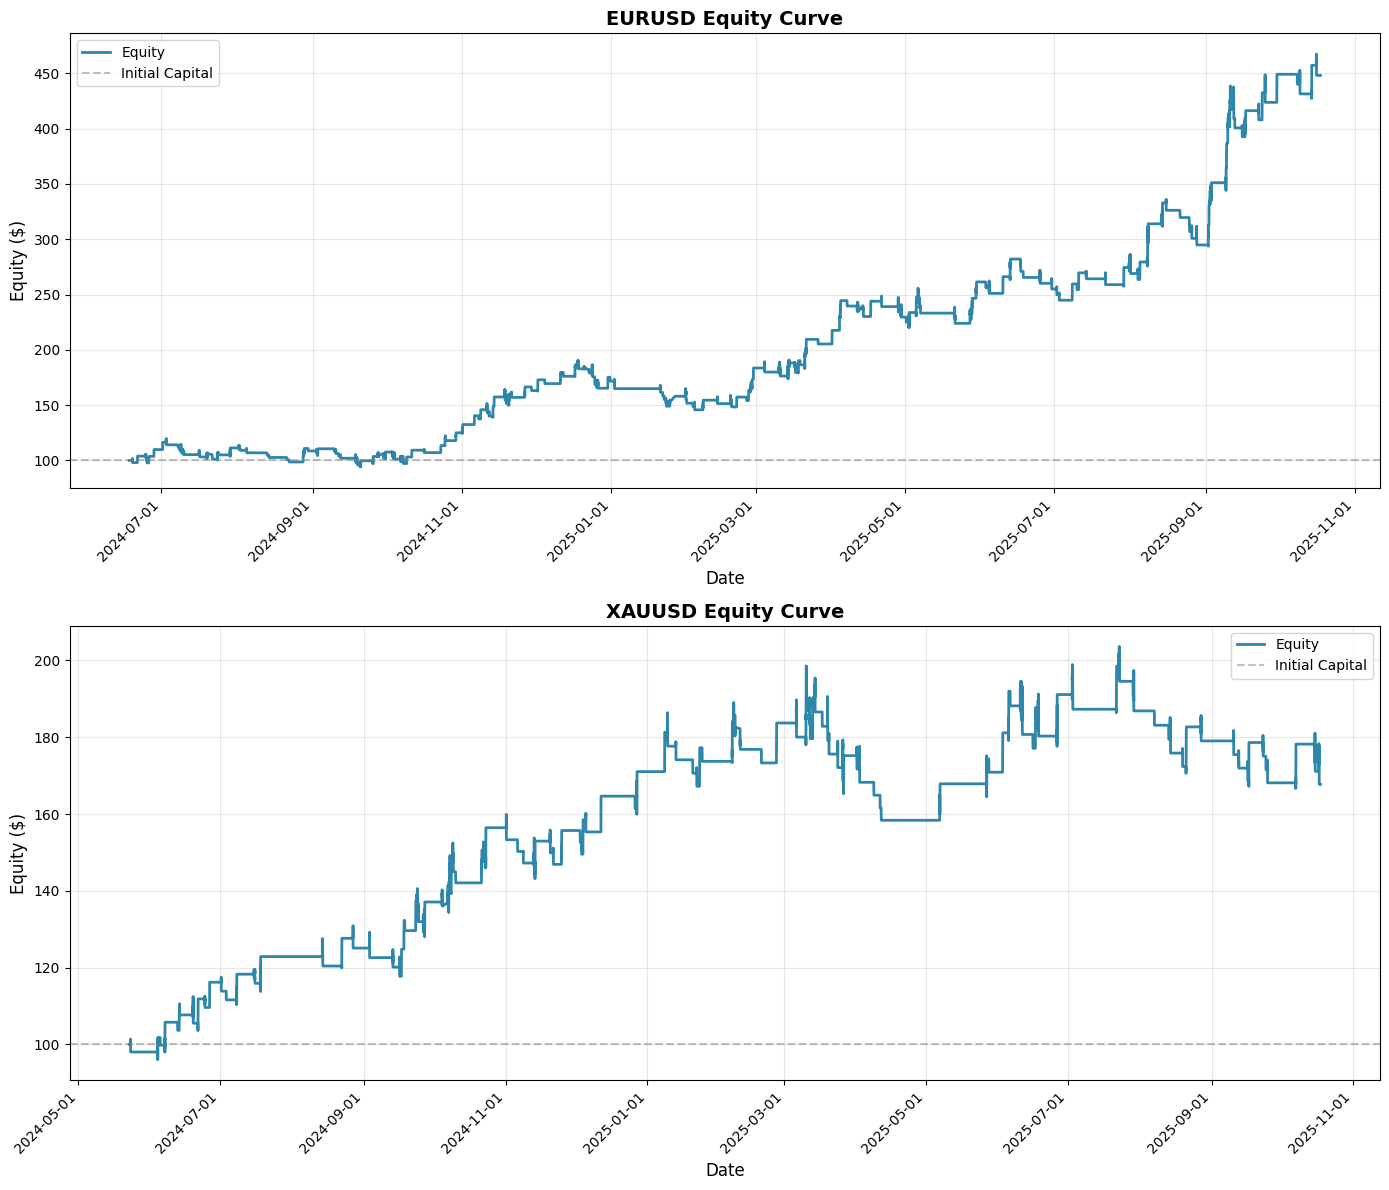

✅ Equity curves plotted


In [12]:
# Plot equity curves for all symbols
fig, axes = plt.subplots(len(SYMBOLS), 1, figsize=(14, 6 * len(SYMBOLS)))

if len(SYMBOLS) == 1:
    axes = [axes]

for idx, symbol in enumerate(SYMBOLS):
    equity_var = f'{symbol}_equity'
    
    if equity_var in globals():
        equity_curve = globals()[equity_var]
        
        ax = axes[idx]
        ax.plot(equity_curve['Date'], equity_curve['Equity'], 
                linewidth=2, color='#2E86AB', label='Equity')
        
        # Add horizontal line for initial capital
        ax.axhline(y=CONFIG['initial_capital'], color='gray', 
                   linestyle='--', alpha=0.5, label='Initial Capital')
        
        ax.set_title(f'{symbol} Equity Curve', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Equity ($)', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("✅ Equity curves plotted")

## Cell 9: Visualize Price and Signals

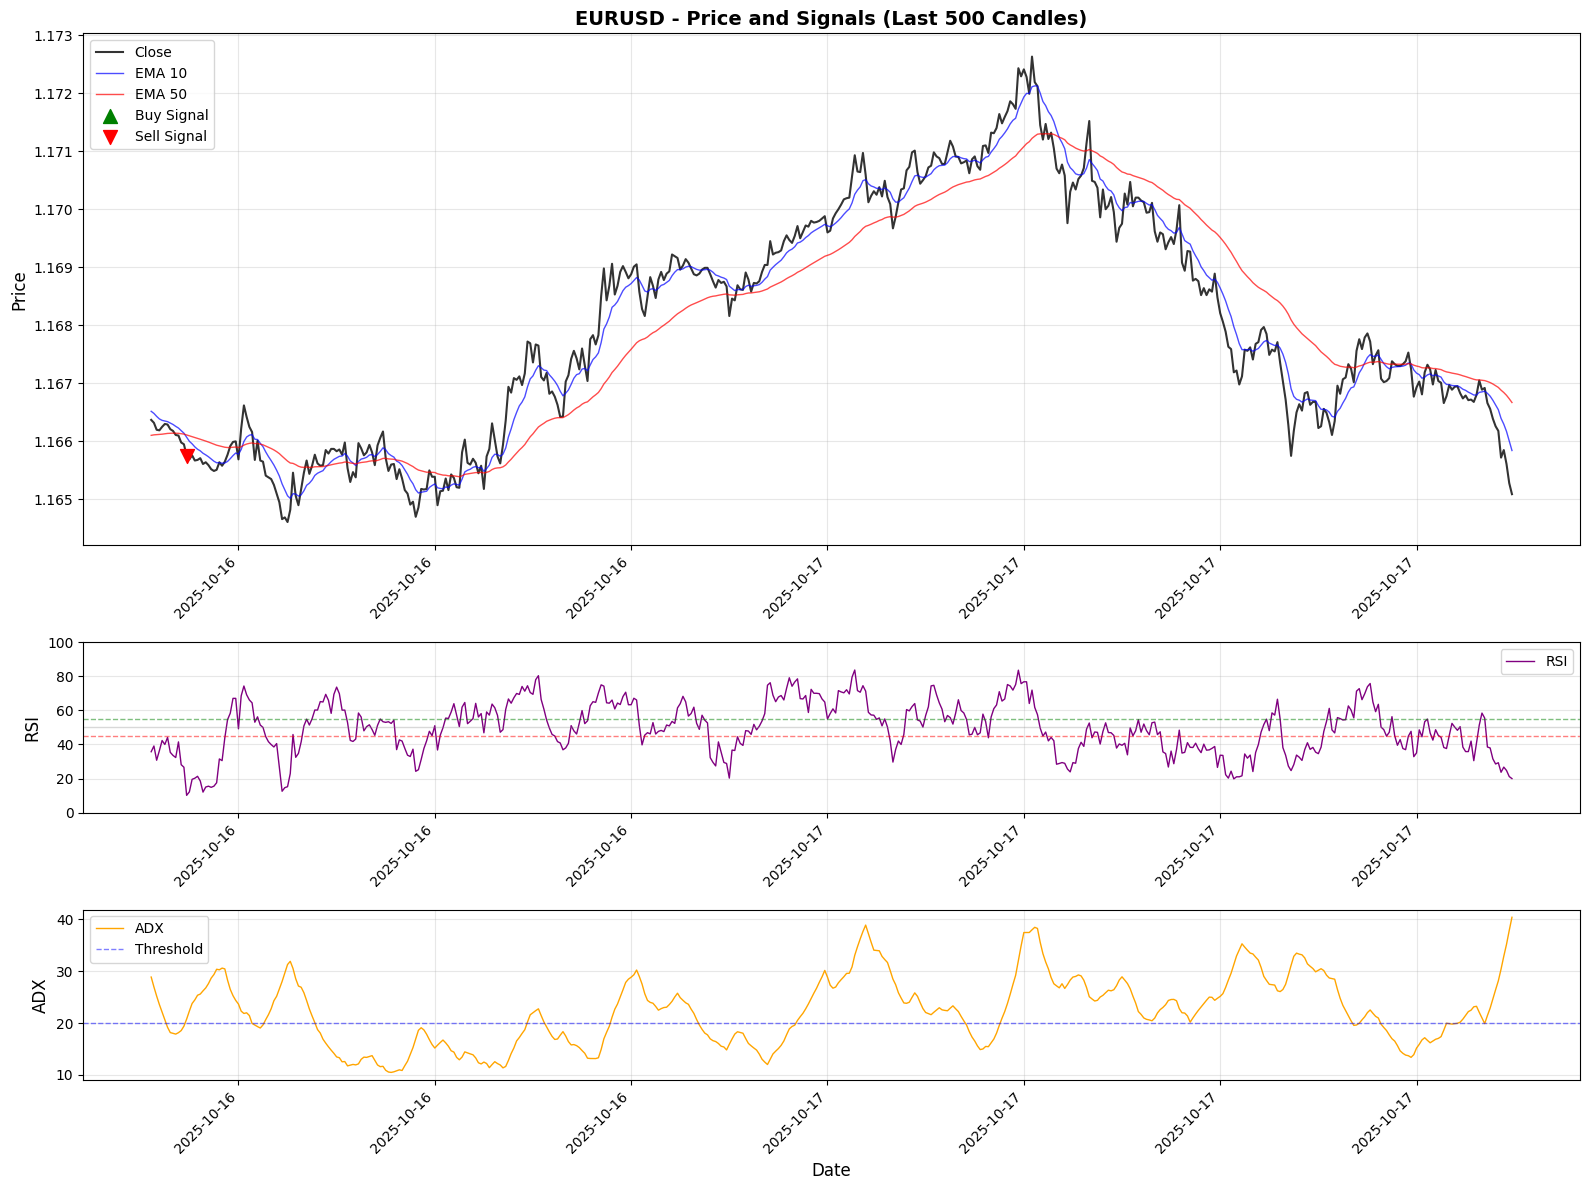

✅ EURUSD chart plotted


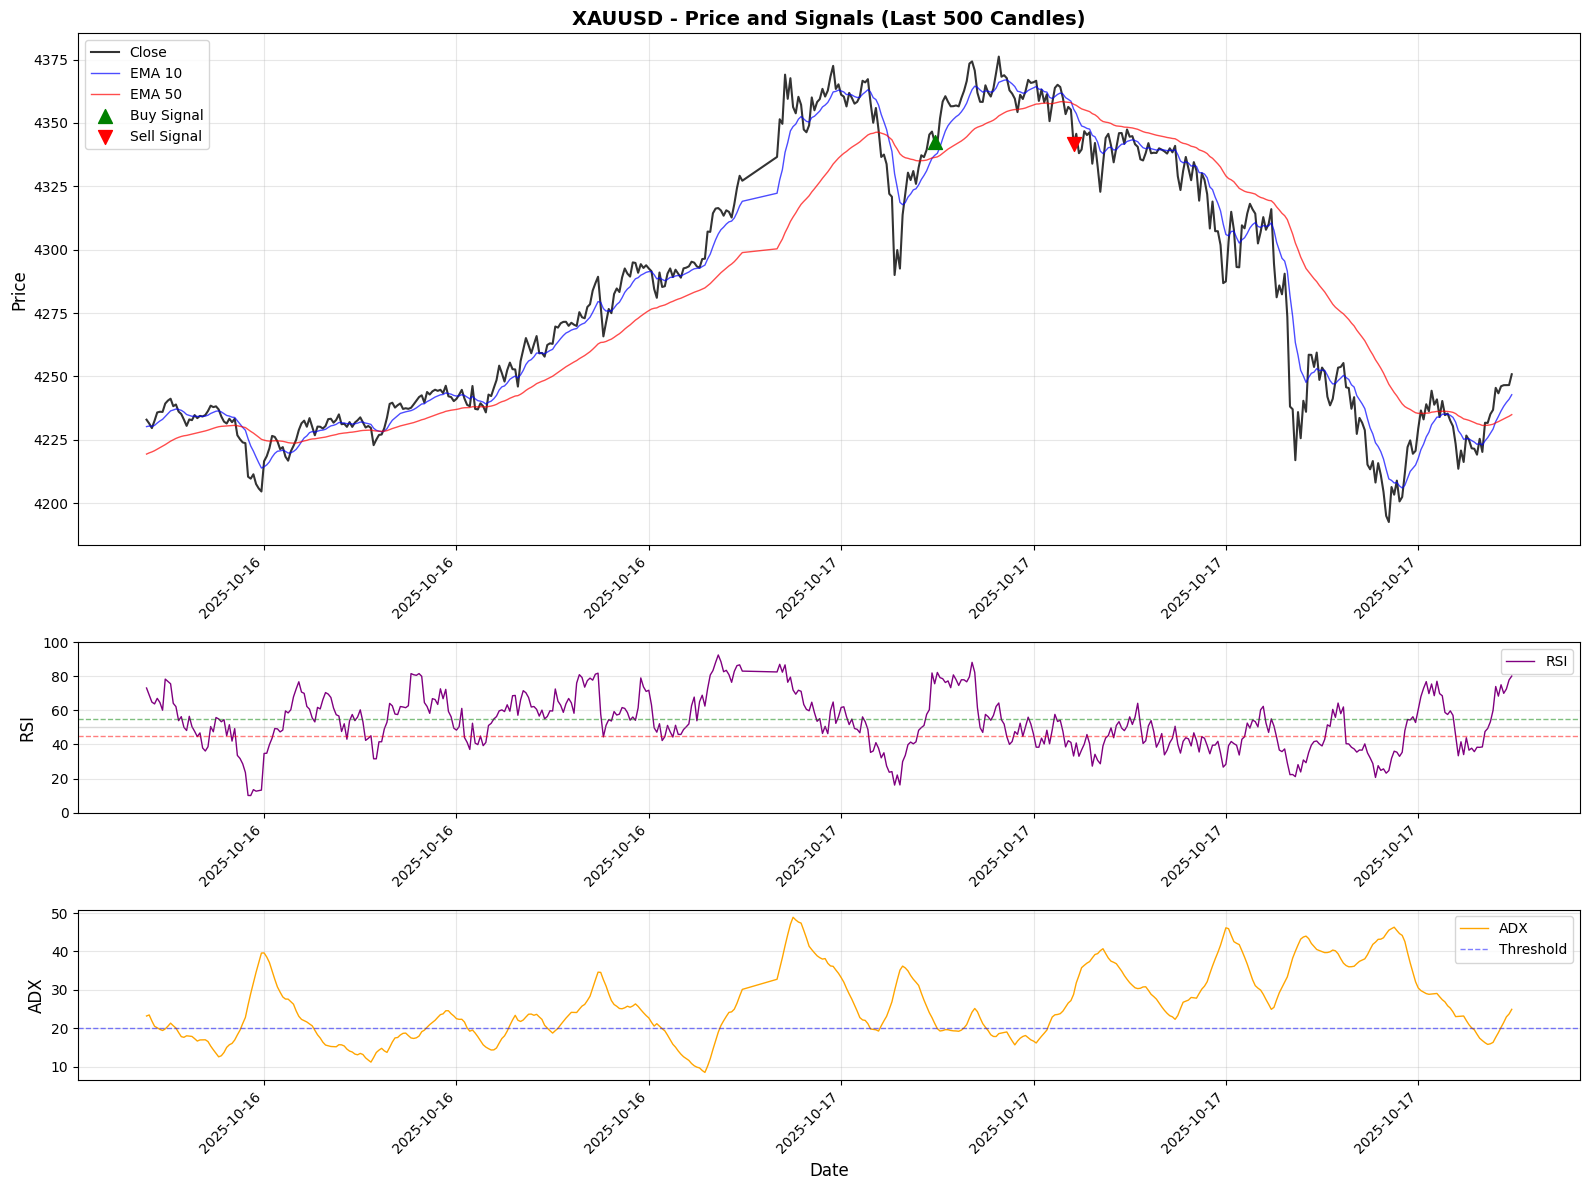

✅ XAUUSD chart plotted

✅ All visualizations complete


In [13]:
# Plot price chart with signals for each symbol
for symbol in SYMBOLS:
    df_var = f'{symbol}_df'
    
    if df_var in globals():
        df = globals()[df_var]
        
        # Limit to last 500 candles for clarity
        df_plot = df.tail(500).copy()
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), 
                                            gridspec_kw={'height_ratios': [3, 1, 1]})
        
        # Price and EMAs
        ax1.plot(df_plot.index, df_plot['Close'], label='Close', 
                linewidth=1.5, color='black', alpha=0.8)
        ax1.plot(df_plot.index, df_plot['EMA_10'], label='EMA 10', 
                linewidth=1, color='blue', alpha=0.7)
        ax1.plot(df_plot.index, df_plot['EMA_50'], label='EMA 50', 
                linewidth=1, color='red', alpha=0.7)
        
        # Plot buy signals
        buy_signals = df_plot[df_plot['Signal'] == 1]
        ax1.scatter(buy_signals.index, buy_signals['Close'], 
                   marker='^', color='green', s=100, label='Buy Signal', zorder=5)
        
        # Plot sell signals
        sell_signals = df_plot[df_plot['Signal'] == -1]
        ax1.scatter(sell_signals.index, sell_signals['Close'], 
                   marker='v', color='red', s=100, label='Sell Signal', zorder=5)
        
        ax1.set_title(f'{symbol} - Price and Signals (Last 500 Candles)', 
                     fontsize=14, fontweight='bold')
        ax1.set_ylabel('Price', fontsize=12)
        ax1.legend(fontsize=10, loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # RSI
        ax2.plot(df_plot.index, df_plot['RSI'], label='RSI', 
                linewidth=1, color='purple')
        ax2.axhline(y=CONFIG['rsi_buy_threshold'], color='green', 
                   linestyle='--', alpha=0.5, linewidth=1)
        ax2.axhline(y=CONFIG['rsi_sell_threshold'], color='red', 
                   linestyle='--', alpha=0.5, linewidth=1)
        ax2.axhline(y=50, color='gray', linestyle='-', alpha=0.3, linewidth=1)
        ax2.set_ylabel('RSI', fontsize=12)
        ax2.set_ylim([0, 100])
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # ADX
        ax3.plot(df_plot.index, df_plot['ADX'], label='ADX', 
                linewidth=1, color='orange')
        ax3.axhline(y=CONFIG['adx_threshold'], color='blue', 
                   linestyle='--', alpha=0.5, linewidth=1, label='Threshold')
        ax3.set_xlabel('Date', fontsize=12)
        ax3.set_ylabel('ADX', fontsize=12)
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # Format x-axis for all subplots
        for ax in [ax1, ax2, ax3]:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ {symbol} chart plotted")

print("\n✅ All visualizations complete")

## Cell 10: Trade Details

In [14]:
# Display detailed trade information
for symbol in SYMBOLS:
    trades_var = f'{symbol}_trades'
    
    if trades_var in globals():
        trades = globals()[trades_var]
        
        if len(trades) > 0:
            trades_df = pd.DataFrame(trades)
            
            print("\n" + "="*70)
            print(f"{symbol} TRADE HISTORY")
            print("="*70)
            
            # Format for display
            display_df = trades_df.copy()
            display_df['Entry Date'] = display_df['Entry Date'].dt.strftime('%Y-%m-%d %H:%M')
            display_df['Exit Date'] = display_df['Exit Date'].dt.strftime('%Y-%m-%d %H:%M')
            display_df['Entry Price'] = display_df['Entry Price'].round(5)
            display_df['Exit Price'] = display_df['Exit Price'].round(5)
            display_df['PnL'] = display_df['PnL'].round(2)
            display_df['PnL %'] = display_df['PnL %'].round(2)
            display_df['Equity'] = display_df['Equity'].round(2)
            
            # Show first 10 and last 10 trades if more than 20
            if len(display_df) > 20:
                print("\nFirst 10 trades:")
                print(display_df.head(10).to_string(index=False))
                print("\n...")
                print("\nLast 10 trades:")
                print(display_df.tail(10).to_string(index=False))
            else:
                print(display_df.to_string(index=False))
        else:
            print(f"\n{symbol}: No trades executed")

print("\n✅ Trade details displayed")


EURUSD TRADE HISTORY

First 10 trades:
      Entry Date        Exit Date  Type  Entry Price  Exit Price  Position Size   PnL  PnL % Exit Reason  Equity
2024-06-19 06:35 2024-06-19 07:05 Short      1.07321     1.07362    4912.280702 -2.00  -2.00   Stop Loss   98.00
2024-06-21 06:50 2024-06-21 07:15 Short      1.07115     1.07013    5770.767613  5.88   5.88 Take Profit  103.88
2024-06-24 15:10 2024-06-24 18:35 Short      1.07275     1.07326    4108.248588 -2.08  -2.08   Stop Loss  101.80
2024-06-24 23:05 2024-06-25 00:00 Short      1.07317     1.07329   17595.476543 -2.04  -2.04   Stop Loss   99.77
2024-06-25 06:25 2024-06-25 06:45 Short      1.07347     1.07372    7992.726340 -2.00  -2.00   Stop Loss   97.77
2024-06-25 23:00 2024-06-26 00:00 Short      1.07113     1.07073   14837.879127  5.87   5.87 Take Profit  103.64
2024-06-28 00:55 2024-06-28 01:25 Short      1.06976     1.06897    7864.075937  6.22   6.22 Take Profit  109.86
2024-07-01 14:20 2024-07-01 15:10 Short      1.07437    